In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
df = pd.read_csv('df_aws_pop.csv', encoding='cp949', parse_dates=['Time']).iloc[:,:8]

In [3]:
df

,Time,Count,Temp,WD,WS,RF,HM,총생활인구수
0,2019-01-01 00:00:00,1,-3.5,347.6,1.6,0.0,62.2,63984.8797
1,2019-01-01 01:00:00,0,-4.0,348.7,0.5,0.0,61.7,51092.5382
2,2019-01-01 02:00:00,0,-4.3,356.4,1.9,0.0,54.8,50045.4346
3,2019-01-01 03:00:00,0,-5.2,338.7,2.2,0.0,67.2,49675.6615
4,2019-01-01 04:00:00,0,-5.7,353.5,1.9,0.0,69.3,49606.5421
...,...,...,...,...,...,...,...,...
26299,2021-12-31 19:00:00,1,-4.7,292.1,4.1,0.0,27.9,71989.4190
26300,2021-12-31 20:00:00,0,-5.2,287.1,4.5,0.0,30.9,63480.4069
26301,2021-12-31 21:00:00,0,-5.5,304.6,3.2,0.0,38.7,55939.8655
26302,2021-12-31 22:00:00,0,-6.2,319.8,4.1,0.0,37.9,53061.3116


In [4]:
df = df.fillna(0)
df['Month'] = df['Time'].dt.month
df['Hour'] = df['Time'].dt.hour
df = df.set_index('Time')

In [5]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

train_df = df[(df.index < '2021-01-01')]
val_df = df[(df.index >= '2021-01-01') & (df.index < '2021-10-01')]
test_df = df[(df.index >= '2021-10-01')]

num_features = df.shape[1]

In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [7]:
tf.random.set_seed(42)

In [8]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df


        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [9]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [10]:
def plot(self, model=None, plot_col='Count', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(20, 12))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [11]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [12]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    result = getattr(self, '_example', None)
    if result is None:
        result = next(iter(self.test))
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [13]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.optimizers.RMSprop(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train,
                        epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [14]:
OUT_STEPS = 1

multi_window = WindowGenerator(input_width=120,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

In [15]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-03 22:36:41.840077: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-03 22:36:41.840168: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance = {}
multi_performance = {}

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/100


2022-04-03 22:36:41.955982: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-03 22:36:42.775808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 22:36:42.922920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 22:36:43.109767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


545/545 [==============================] - ETA: 0s - loss: 0.4339 - mean_absolute_error: 0.3901

2022-04-03 22:36:56.969199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 22:36:57.013016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


545/545 [==============================] - 18s 30ms/step - loss: 0.4339 - mean_absolute_error: 0.3901 - val_loss: 0.9568 - val_mean_absolute_error: 0.6218
Epoch 2/100
545/545 [==============================] - 16s 29ms/step - loss: 0.2716 - mean_absolute_error: 0.2770 - val_loss: 0.5486 - val_mean_absolute_error: 0.4687
Epoch 3/100
545/545 [==============================] - 16s 29ms/step - loss: 0.2358 - mean_absolute_error: 0.2455 - val_loss: 0.4186 - val_mean_absolute_error: 0.4021
Epoch 4/100
545/545 [==============================] - 16s 30ms/step - loss: 0.2218 - mean_absolute_error: 0.2314 - val_loss: 0.3588 - val_mean_absolute_error: 0.3596
Epoch 5/100
545/545 [==============================] - 16s 30ms/step - loss: 0.2143 - mean_absolute_error: 0.2237 - val_loss: 0.3284 - val_mean_absolute_error: 0.3353
Epoch 6/100
545/545 [==============================] - 16s 30ms/step - loss: 0.2095 - mean_absolute_error: 0.2187 - val_loss: 0.3120 - val_mean_absolute_error: 0.3209
Epoch 7/10

In [17]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
23,0.171157,0.207181,0.289410,0.291550,23
24,0.171524,0.206867,0.299332,0.303760,24
25,0.170193,0.206932,0.300647,0.301630,25
26,0.166762,0.206693,0.291352,0.294485,26
27,0.167305,0.206077,0.301796,0.298328,27
28,0.162729,0.205212,0.309658,0.300903,28
29,0.162100,0.205933,0.298014,0.296783,29
30,0.158918,0.205506,0.299550,0.297520,30
31,0.157888,0.205663,0.295322,0.295028,31
32,0.156079,0.205019,0.301769,0.297016,32


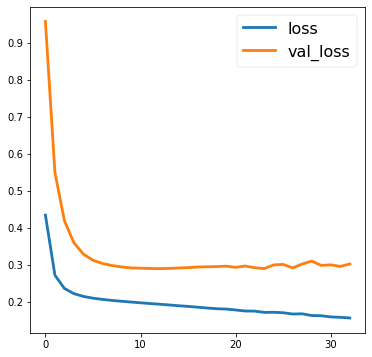

In [18]:
fig, ax = plt.subplots(figsize=(6,6))

plt.style.use('seaborn-poster')
plt.plot(hist['epoch'], hist['loss'], label='loss')
plt.plot(hist['epoch'], hist['val_loss'], label='val_loss')
plt.legend()
plt.show()

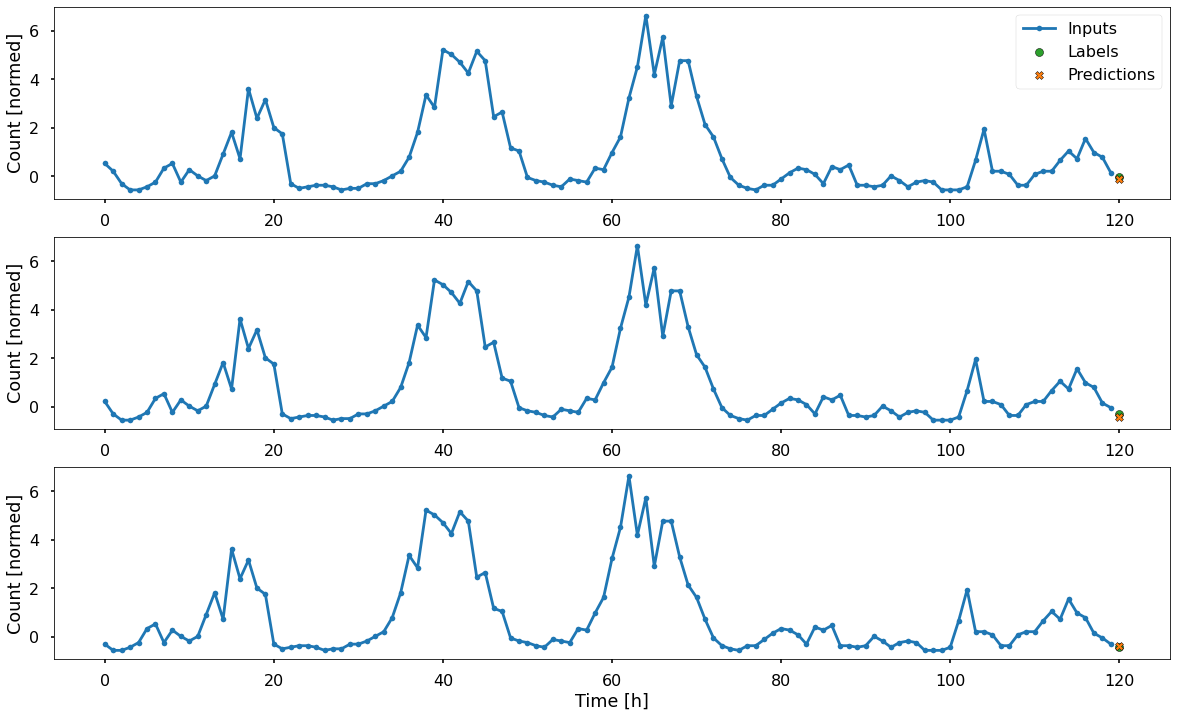

In [19]:
multi_window.plot(multi_lstm_model)

In [38]:
res_lstm = []

for i in range(multi_lstm_model.predict(multi_window.test).shape[0]) :
    j = 96 + (1 * i)
    res = pd.DataFrame(multi_lstm_model.predict(multi_window.test)[i], columns = ['FCST_Count', 'Temp', 'WD', 'WS', 'RF', 'HM', '총생활인구수', 'Month', 'Hour'])[['FCST_Count']]
    tests = test_df[j:].head(1).reset_index()[['Time', 'Count']].join(res)
    tests['Count'] = tests['Count'] * train_std['Count'] + train_mean['Count']
    tests['FCST_Count'] = tests['FCST_Count'] * train_std['Count'] + train_mean['Count']
    tests['FCST_Count'] = tests['FCST_Count'].apply(lambda x : 0 if x < 0 else x)
    res_lstm.append(tests)

In [39]:
result_lstm = pd.concat(res_lstm)

In [40]:
fig, ax = plt.subplots(figsize=(20,10))

plt.plot(result_lstm.Time, result_lstm.Count, label='count')
plt.plot(result_lstm.Time, result_lstm.FCST_Count, label='LSTM')
plt.legend()
plt.show()

In [41]:
result_lstm.to_csv('lstm.csv', encoding='cp949', index=False)